
<i>Last updated 31 May 2023</i>
<h1> Random Forest: A Tutorial for Drought Prediction and Beyond </h1>

In this tutorial, we will cover the following topics:

1. A brief introduction to Random Forest<br>
2. Python packages that support Random Forest<br>
3. Modeling with Random Forest<br>
    a. Training a Random Forest for binary classification (drought vs. non-drought)<br>
    b. Predicting on test data using the trained model<br>
    c. Evaluating model performance<br>
    d. Feature importance analysis
    e. Training with different seeds
4. Final remarks

---

<h2> 1. A brief introduction to Random Forest </h2>

Random Forest is an ensemble learning method that can be used for both classification and regression tasks. It works by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In the case of classification, the split at each node is determined by selecting the best split point that maximizes the Gini impurity reduction. For regression, the split is chosen to minimize the mean squared error.

The main parameters that need to be tuned in a Random Forest model are:

<i>n_estimators :</i> The number of trees in the forest<br>
<i>max_depth :</i> The maximum depth of the tree<br>
<i>min_samples_split :</i> The minimum number of samples required to split an internal node<br>
<i>min_samples_leaf :</i> The minimum number of samples required to be at a leaf node<br>
<i>max_features :</i> The number of features to consider when looking for the best split<br>

<h2> 2. Python Packages that support Random Forest </h2>

Here are some popular Python packages that support Random Forest:

**Scikit-learn**  - RandomForestClassifier and RandomForestRegressor (CPU only) (Installed in hh5 analysis3)<br>
**RAPIDS**  - RandomForestClassifier and RandomForestRegressor (GPU only) (Installed in NCI dk92)<br>
**XGBoost**  - XGBClassifier and XGBRegressor (CPU and GPU support) (Installed in NCI dk92)<br>
**LightGBM**  - LGBMClassifier and LGBMRegressor (CPU and GPU support) <br>
**CatBoost**  - CatBoostClassifier and CatBoostRegressor (CPU and GPU support) <br>

<h2> 3. Modeling with Random Forest </h2>

The dataset we are working with contains records of both drought and non-drought events that took place in Texas. Each event is accompanied by measurements of various climate variables. Our goal is to train a model that can accurately predict whether the climate conditions in a given month correspond to a drought or a non-drought situation.<br>

This task can be framed as a binary classification problem, where the target variable is either '1' for drought or '0' for non-drought. The predictors are the climate variables.<br>

For this example, we will use the **RandomForestClassifier** from the **scikit-learn** package. <br><br>

First, we need to import the necessary libraries and load our dataset. We will assume that the dataset has been preprocessed and is ready for modeling.

In [1]:
# Data

import numpy as np
import pandas as pd

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Jupyter lab widgets

import ipywidgets as widgets
from IPython.display import display

# Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

/jobfs/88419830.gadi-pbs/ipykernel_4084245/3066757893.py:10: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Load dataset
data = pd.read_csv('/g/data/hh5/tmp/CLEX-WinterSchool-2023/ML-Drought-Prediction-Tutorial/Data/Texas_drought_data.csv')

# Drop rows with missing values
data.dropna(axis=0, inplace=True)

# Display the first 3 lines of data
print(data.head(3))

predictors = ['P', 'PET', 'ET', 'SM', 'SM_prev', 'DS', 'NDVI', 'enso', 'month']
target = 'drought'

       lon   lat name  year  month  drought  enso         PET           P  \
164 -100.3  35.4   P1  1993      7      0.0  0.94  171.309067  145.589996   
165 -100.3  35.4   P1  1993      8      0.0  0.92  153.120987   64.680000   
182 -100.3  35.4   P1  1995     12      1.0  0.01   34.788197   38.160000   

             ET         SM    SM_prev  DS     NDVI  
164  107.159248  22.027588  21.143407  14  0.47751  
165   73.903336  25.876668  22.027588   1  0.45252  
182    1.417211  20.852627  19.864197   3  0.29096  


Predictors include Precipitation <i>(**P**)</i>, <i>Evapotranspiration (**ET**)</i>, <i>Potential Evapotranspiration (**PET**)</i>, <i>Soil moisture (**SM**)</i>, <i>Soil moisture of the previous month (**SM_prev**)</i>, <i>ENSO index (**enso**)</i>, <i>**NDVI**</i>, and the <i>**month**</i> at which the event occurred.The traget variable is <i>**drought**</i>. <br>
For more details on the data source, refer to **Table 1** in <a href="https://doi.org/10.1029/2021WR031829">(Hobeichi et al., 2022)</a>.

The following script shows the locations of the recorded drought events in drought impact reports and climate statements

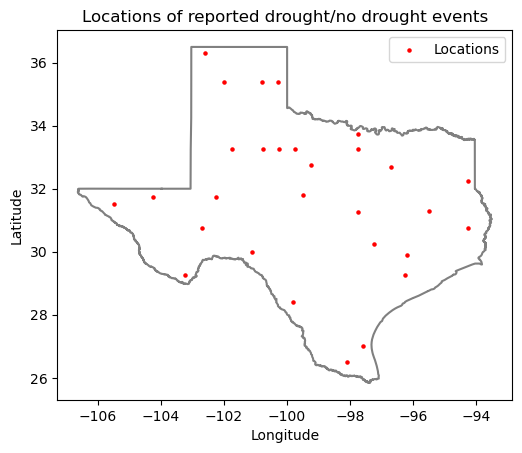

In [3]:
# Find unique points
unique_points = data[['lon', 'lat']].drop_duplicates()

# Create a GeoDataFrame from the unique locations
geometry = [Point(xy) for xy in zip(unique_points['lon'], unique_points['lat'])]
unique_points_gdf = gpd.GeoDataFrame(unique_points, geometry=geometry)

# Load a GeoDataFrame with the geometries of the US states
usa = gpd.read_file('/g/data/hh5/tmp/CLEX-WinterSchool-2023/ML-Drought-Prediction-Tutorial/Data/usa_boundaries/tl_2019_us_state.shp')
texas = usa[usa['NAME'] == 'Texas']['geometry'].values[0]
lon, lat = texas.exterior.xy


# Plot the unique locations on a map of Texas
fig, ax = plt.subplots()
ax.plot(lon,lat, c='grey')
unique_points_gdf.plot(ax=ax, color='red', markersize=5, label='Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of reported drought/no drought events')
plt.legend()
plt.show()

To check if the original dataset is balanced, we can count the number of occurrences of each class in the target variable and calculate their respective proportions. A balanced dataset will have approximately equal proportions of each class.<br><br>
This script will display the class counts and proportions and determine if the dataset is balanced or imbalanced based on the specified threshold (10%). We can adjust the <i>**balanced_threshold**</i> variable to change the tolerance for class imbalance.

In [4]:
# Predictors dataframe
X = data[predictors]
# Display the first 3 lines
print("predictors: \n",X.head(3))

# Target data array
y = data[target]
# Display the first 3 lines
print("\n\ntarget: \n", y.head(3))

# Count the number of occurrences of each class in the target variable
class_counts = y.value_counts()

# Calculate the proportions of each class
class_proportions = class_counts / len(y)

# Display class counts and proportions
print("Class counts:\n", class_counts)
print("\nClass proportions:\n", class_proportions)

# Check if the dataset is balanced
balanced_threshold = 0.1  # Define a threshold for class imbalance (e.g., 0.1 for 10%)
is_balanced = np.all(np.abs(class_proportions - 0.5) <= balanced_threshold)

if is_balanced:
    print("\nThe dataset is balanced.")
else:
    print("\nThe dataset is imbalanced.")

predictors: 
               P         PET          ET         SM    SM_prev  DS     NDVI  \
164  145.589996  171.309067  107.159248  22.027588  21.143407  14  0.47751   
165   64.680000  153.120987   73.903336  25.876668  22.027588   1  0.45252   
182   38.160000   34.788197    1.417211  20.852627  19.864197   3  0.29096   

     enso  month  
164  0.94      7  
165  0.92      8  
182  0.01     12  


target: 
 164    0.0
165    0.0
182    1.0
Name: drought, dtype: float64
Class counts:
 0.0    505
1.0    499
Name: drought, dtype: int64

Class proportions:
 0.0    0.502988
1.0    0.497012
Name: drought, dtype: float64

The dataset is balanced.


Given the balanced distribution of drought and non-drought events in our dataset, there is no need to address the issue of imbalanced data.

<h3>3.a Training a Random Forest for Binary Classification (drought vs. non-drought)</h3>

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest model
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

It is important to specify a value for the <i>random_state</i> in order to ensure reproducible results.<br> 
Here, 30% of the data is held back for model evaluation and is not used in the training process.<br> 
The Random Forest model is built using 500 trees.<br> 

One advantage of using Random Forest is that it does not require extensive hyperparameter tuning or normalisation of predictors, unlike most of the other machine learning algorithms.

<h3> 3.b Predicting on test data using the trained model</h3>
Once we have trained our Random Forest model, we can use it to predict on the test data:

In [6]:
# Predict on test data
y_pred = clf.predict(X_test)

# Display y_pred array
print("Predicted classes for the test data:\n", y_pred)

# Calculate the number of droughts and non-droughts in y_pred
drought_count = np.sum(y_pred == 1)
non_drought_count = np.sum(y_pred == 0)

print(f"\nNumber of predicted droughts: {drought_count}")
print(f"Number of predicted non-droughts: {non_drought_count}")

Predicted classes for the test data:
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.]

Number of predicted droughts: 145
Number 

The y_pred array contains the predicted classes (drought or non-drought) for each data point in the test dataset.<br>
Displaying the total number of predicted droughts and non-droughts can be useful to understand the distribution of the predictions made by the model.<br>

The trained model can also predict the likelihood of each classification, such as the likelyhood of a drought based on the climate conditions. This can be achieved through the use of <i>**predict_proba**</i> function. 

In [7]:
# Predict class probabilities for the test data
y_pred_proba = clf.predict_proba(X_test)

# Display y_pred_proba array
#print("Predicted class probabilities for the test data:\n", y_pred_proba)

# Extract the probability of drought (class 1) for each data point in the test dataset
drought_probabilities = y_pred_proba[:, 1]

print("Probability of drought for each data point in the test dataset:\n", drought_probabilities)

Probability of drought for each data point in the test dataset:
 [0.006 0.14  0.27  0.06  0.966 0.194 0.132 0.308 0.02  0.52  0.82  1.
 0.218 0.052 0.962 0.052 0.192 0.948 0.926 0.032 0.182 0.912 0.83  0.972
 0.926 0.14  0.57  0.236 0.06  0.898 0.942 0.02  0.914 0.6   0.488 0.922
 0.022 0.12  0.11  0.948 0.046 0.066 0.002 0.002 0.022 0.884 0.066 0.954
 0.99  0.02  0.004 0.98  0.892 0.974 0.15  0.696 0.922 0.736 0.994 0.96
 0.37  0.92  0.182 0.954 0.684 0.212 0.952 0.082 0.098 0.938 0.072 0.844
 0.878 0.074 0.952 0.356 0.324 0.008 0.838 0.012 0.948 0.926 0.318 0.61
 0.546 0.01  0.004 0.252 0.994 0.996 0.952 0.012 0.382 0.312 0.338 0.052
 0.836 0.922 0.606 0.972 0.986 0.198 0.89  0.814 0.038 0.114 0.94  0.758
 0.034 0.222 0.058 0.99  0.    0.954 0.196 0.708 0.844 0.7   0.594 0.016
 0.628 0.846 0.066 0.986 0.058 0.098 0.554 0.976 0.236 0.084 0.022 0.01
 0.394 0.704 0.06  0.812 0.846 0.882 0.692 0.998 0.252 0.242 0.82  0.214
 0.608 0.03  0.756 0.132 0.98  0.376 0.09  0.834 0.96  0.966 0.01

In [8]:
# range of each predictor
ranges = {
    'enso': [-4, 4],
    'PET': [10, 250],
    'P': [0, 700],
    'ET': [-10, 200],
    'SM': [0, 60],
    'SM_prev': [0, 60],
    'DS': [-150, 200],
    'NDVI': [0, 1],
    'month': [1, 12]
}

def predict_drought_probability(change):
    # Get input values
    input_values = [float(entry.value) for entry in entries]

    # Predict the probability of drought
    prob = clf.predict_proba([input_values])[0][1]

    # Display the result
    result_label.value = f"Probability of drought: {prob:.2f}"

# Create input fields
entries = []
for idx, predictor in enumerate(predictors):
    label = widgets.Label(value=f"{predictor} ({ranges[predictor][0]}, {ranges[predictor][1]})")
    entry = widgets.FloatText(value=0, min=ranges[predictor][0], max=ranges[predictor][1])
    entries.append(entry)

    box = widgets.HBox([label, entry])
    display(box)

# Create the 'Predict' button
predict_button = widgets.Button(description="Predict")
predict_button.on_click(predict_drought_probability)
display(predict_button)

# Create a label to display the result
result_label = widgets.Label(value="")
display(result_label)

Button(description='Predict', style=ButtonStyle())

Label(value='')

Next, input your own set of predictors and see in each case the predicted probability of drought by the trained Random Forest model

<h3> 3.c Evaluating model performance</h3>

To compute the accuracy and other performance metrics, we can use the functions provided by <i>**scikit-learn**</i>. We will calculate precision, recall, F1-score, and accuracy

In [9]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Display performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

print("\nPerformance Metrics Explained:")
print("Accuracy: The proportion of correct predictions (both droughts and non-droughts) out of all predictions.")
print("Precision: The proportion of true droughts out of all the predicted droughts. High precision indicates a low number of false positives (non-droughts predicted as droughts).")
print("Recall: The proportion of true droughts out of all the actual droughts. High recall indicates a low number of false negatives (droughts predicted as non-droughts).")
print("F1-score: The harmonic mean of precision and recall. It is a single metric that balances the trade-off between precision and recall.")
print("Balanced Accuracy: The average of recall obtained on each class. It is useful for imbalanced datasets, as it takes into account the performance on both minority and majority classes.")


Accuracy: 0.91
Precision: 0.94
Recall: 0.88
F1-score: 0.91
Balanced Accuracy: 0.91

Performance Metrics Explained:
Accuracy: The proportion of correct predictions (both droughts and non-droughts) out of all predictions.
Precision: The proportion of true droughts out of all the predicted droughts. High precision indicates a low number of false positives (non-droughts predicted as droughts).
Recall: The proportion of true droughts out of all the actual droughts. High recall indicates a low number of false negatives (droughts predicted as non-droughts).
F1-score: The harmonic mean of precision and recall. It is a single metric that balances the trade-off between precision and recall.
Balanced Accuracy: The average of recall obtained on each class. It is useful for imbalanced datasets, as it takes into account the performance on both minority and majority classes.


We have to use <i>**Balanced Accuracy**</i> instead of <i>**Accuracy**</i> if the dataset is imbalanced

<h3>3.d Feature importance analysis</h3>

To calculate the variable importance of each predictor using the Random Forest model, we can access the <i>**feature_importances_ attribute**</i> of the trained model. We can then find the most important predictor and check if any of the importances are negative and conclude that the predictor doesn't provide any predictability in that case.
Note that in practice, the feature importances provided by the <i>**RandomForestClassifier**</i> in <i>**scikit-learn**</i> are generally non-negative. However, other packages can calculate negative variable importance<br>

To display the calculated variable importance in a bar graph, we can use the <i>**matplotlib**</i> library. 

Variable Importances:
 [0.26201709 0.04993261 0.04925779 0.21070918 0.0941042  0.06058976
 0.05634102 0.18862815 0.0284202 ]

Negative Importance Indicators:
 [False False False False False False False False False]

No predictors have negative importance values. All predictors provide some degree of predictability.


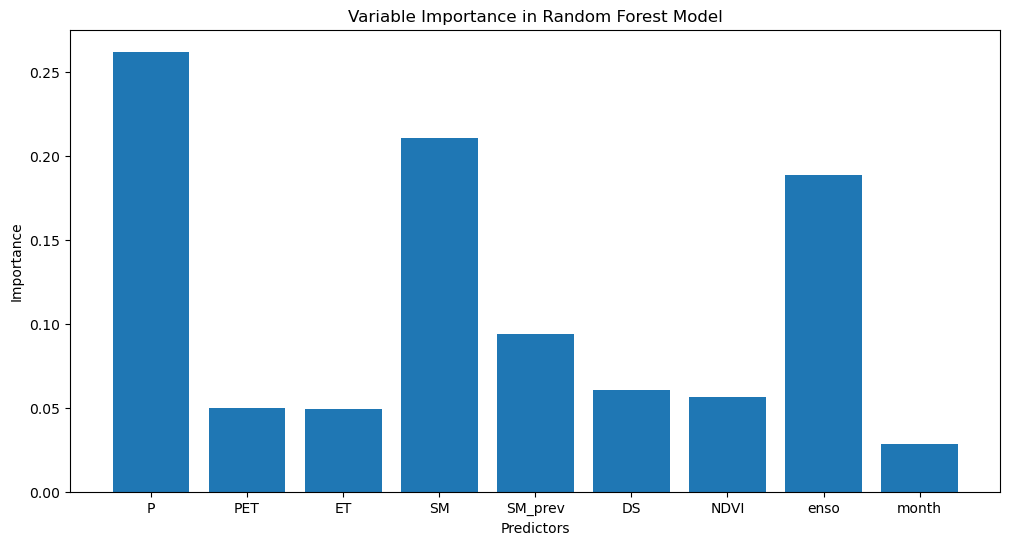

Ranking of predictors based on variable importance:
  Predictor  Variable Importance  Rank
0         P             0.262017     1
1        SM             0.210709     2
2      enso             0.188628     3
3   SM_prev             0.094104     4
4        DS             0.060590     5
5      NDVI             0.056341     6
6       PET             0.049933     7
7        ET             0.049258     8
8     month             0.028420     9


In [10]:
# Calculate variable importance using the Random Forest model
variable_importance = clf.feature_importances_

# Check if any variable importances are negative
negative_importance = variable_importance < 0

# Display variable importances and negative importance indicators
print("Variable Importances:\n", variable_importance)
print("\nNegative Importance Indicators:\n", negative_importance)

# Conclude if predictors with negative importances don't provide any predictability
if np.any(negative_importance):
    print("\nPredictors with negative importance values do not provide any predictability.")
else:
    print("\nNo predictors have negative importance values. All predictors provide some degree of predictability.")


# Create a bar graph of variable importances
plt.figure(figsize=(12, 6))
plt.bar(X.columns, variable_importance)
plt.xlabel('Predictors')
plt.ylabel('Importance')
plt.title('Variable Importance in Random Forest Model')
plt.show()

# To display the ranking of the predictors
# Get the indices that would sort the variable importance array in descending order
sorted_indices = np.argsort(variable_importance)[::-1]

# Create a DataFrame to display predictors and their rankings
ranking_df = pd.DataFrame({
    'Predictor': X.columns[sorted_indices],
    'Variable Importance': variable_importance[sorted_indices],
    'Rank': np.arange(1, len(X.columns) + 1)
})

# Print the ranking of predictors based on variable importance
print("Ranking of predictors based on variable importance:")
print(ranking_df)



<h4> What can the feature importance analysis tell us? </h4>

1. Feature selection: Variable importance can guide us in selecting the most relevant predictors for our prediction task, allowing us to build more parsimonious models with fewer predictors. This may lead to better generalization, easier interpretation, and reduced computational complexity.

2. Domain knowledge: By evaluating the importance of predictors, we can validate our domain knowledge and scientific understanding of the phenomena. For example, if we find that certain predictors have a higher importance, this might confirm existing hypotheses about the role of these factors in causing droughts.

<h3>3.e Training with different seeds</h3>

Training Random Forest with different seeds and analysing the variability of the results helps to assess the stability and generalisability of the model, which are crucial aspects of building a reliable machine learning model.<br>
This updated script performs a new train-test split in each iteration and calculates the mean performance metrics across the 30 iterations. This approach provides an even better assessment of the model's stability and generalisability by considering the variability introduced by different splits of the data.


Mean Accuracy: 0.898
Mean Precision: 0.901
Mean Recall: 0.898
Mean F1-score: 0.899
Mean Balanced Accuracy: 0.899


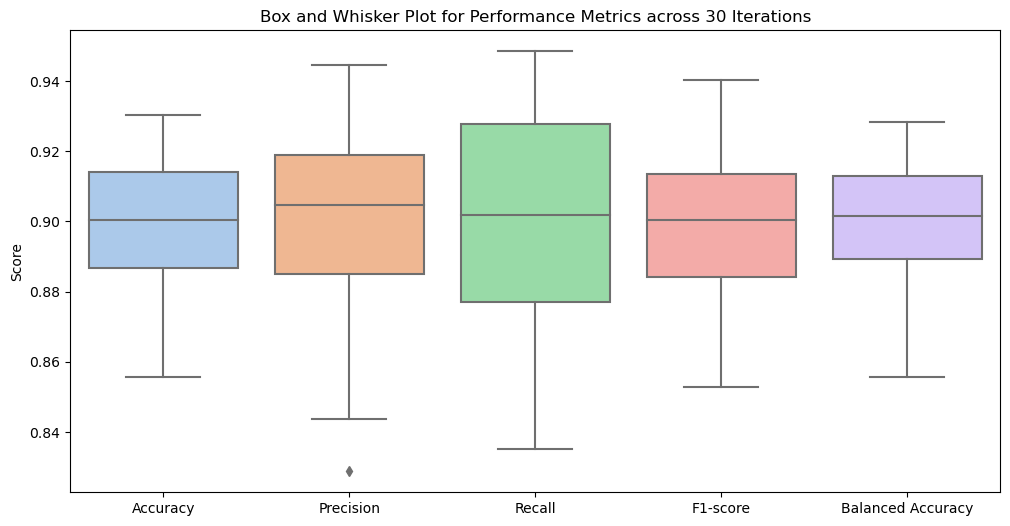

In [11]:
n_iterations = 30
seeds = np.arange(n_iterations)

# Initialize arrays to store performance metrics
accuracy_scores = np.zeros(n_iterations)
precision_scores = np.zeros(n_iterations)
recall_scores = np.zeros(n_iterations)
f1_scores = np.zeros(n_iterations)
balanced_accuracy_scores = np.zeros(n_iterations)

# Train the model and calculate performance metrics for each iteration
for i, seed in enumerate(seeds):
    # Split the data into training and testing sets for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Train the Random Forest model with a different seed
    clf = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = clf.predict(X_test)

    # Calculate performance metrics
    accuracy_scores[i] = accuracy_score(y_test, y_pred)
    precision_scores[i] = precision_score(y_test, y_pred)
    recall_scores[i] = recall_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)
    balanced_accuracy_scores[i] = balanced_accuracy_score(y_test, y_pred)

# Calculate the mean performance metrics
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_balanced_accuracy = np.mean(balanced_accuracy_scores)

# Display mean performance metrics
print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Mean Precision: {mean_precision:.3f}")
print(f"Mean Recall: {mean_recall:.3f}")
print(f"Mean F1-score: {mean_f1:.3f}")
print(f"Mean Balanced Accuracy: {mean_balanced_accuracy:.3f}")


# Create a DataFrame to store the performance metrics for each iteration
performance_df = pd.DataFrame({
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores,
    'Balanced Accuracy': balanced_accuracy_scores
})

# Draw a  box and whisker plot to display the results of each performance metric across 30 iterations
plt.figure(figsize=(12, 6))
sns.boxplot(data=performance_df, palette="pastel")
plt.ylabel('Score')
plt.title('Box and Whisker Plot for Performance Metrics across 30 Iterations')
plt.show()



The model's performance is consistent across different seeds. This suggests that the model is less sensitive to the randomness introduced during training and is more likely to perform well on unseen data.

<h2> 4. Final remarks</h2>
Through this tutorial, we learned how to apply the Random Forest algorithm to a practical problem (drought prediction) and gained insights into important aspects of model evaluation and feature importance.

The concepts and techniques learned in this tutorial can be easily applied to other prediction tasks, such as predicting the probability of bushfires, extreme events, or hail occurrences, given a set of climate predictors. 

To apply these concepts to these new problems, we would follow similar steps:

1. Collect and preprocess the dataset containing relevant climate predictors and the target variable (bushfire occurrence, extreme event occurrence, or hail occurrence). (Not covered here, but you can follow the approach described in <a href="https://doi.org/10.1029/2021WR031829">(Hobeichi et al., 2022)</a>. )

2. Perform the train-test split to separate the data into training and testing datasets.

3. Train a Random Forest model using the training dataset.

4. Predict the probabilities of the target class (e.g., bushfire, extreme event, or hail) for the test dataset using the trained model.

5. Evaluate the model's performance using various performance metrics, such as accuracy, precision, recall, F1-score, and balanced accuracy.

6. Assess the importance of the predictors using the Random Forest model to identify the most influential factors for the prediction task. Consider removing predictors that have limited predictiveness, and then repeat steps 2, 3, 4, and 5 to determine if the model's performance remains the same (or improves) without their inclusion.

7. Test the model's stability and generalisability by training it multiple times with different seeds and train-test splits, and calculate the mean performance metrics across the iterations.



<h4><center>--- End of Tutorial ---</center></h4>

**Credits**<br>
Author :  Dr. Sanaa Hobeichi<sup>1</sup>,<a href=s.hobeichi@unsw.edu.au> s.hobeichi@unsw.edu.au</a><br>
Technical Assistant : Dr. Sam Green<sup>1</sup><br>
Design Contributor :  A/Prof. Gab Abramowitz<sup>1</sup><br><br>
<i><sup>1</sup>ARC Centre of Excellence for Climate Extremes & The University of New South Wales Sydney</i><br>

**Disclaimer**<br>
This tutorial was generated with the help of OpenAI's language model, ChatGPT4, and refined by the author. While every effort has been made to ensure the accuracy of the information presented, please note that the contents of this tutorial are for educational purposes only and should not be relied upon for making business, legal, or other decisions.